In [136]:
%matplotlib inline
import matplotlib.pyplot as plt
import overpy
import numpy as np
import osmnx as ox

In [37]:
# 39.37069/-76.70787
# 39.26592/-76.55389


TRAFFIC_SIGNAL_QUERY = """
[out:json]
[timeout:2500]
;
area(3600133345)->.searchArea;
(
  node
    ["highway"="traffic_signals"]
    (area.searchArea);
  way
    ["highway"="traffic_signals"]
    (area.searchArea);
  relation
    ["highway"="traffic_signals"]
    (area.searchArea);
);
out;
>;
out skel qt;
"""

In [278]:
# 39.37069/-76.70787
# 39.26592/-76.55389


TRAFFIC_SIGNAL_QUERY = """
[out:json]
[timeout:2500]
;
area["name"="Baltimore"]->.searchArea;
(
  node
    ["highway"="traffic_signals"]
    (area.searchArea);
  way
    ["highway"="traffic_signals"]
    (area.searchArea);
  relation
    ["highway"="traffic_signals"]
    (area.searchArea);
);
out;
>;
out skel qt;
"""
response = api.query(TRAFFIC_SIGNAL_QUERY)

In [280]:
response.nodes

[<overpy.Node id=37802386 lat=39.3719242 lon=-76.7112934>,
 <overpy.Node id=49378204 lat=39.3227438 lon=-76.6665613>,
 <overpy.Node id=49378234 lat=39.3277398 lon=-76.6651853>,
 <overpy.Node id=49378332 lat=39.3365617 lon=-76.6740430>,
 <overpy.Node id=49378369 lat=39.3412033 lon=-76.6831035>,
 <overpy.Node id=49378379 lat=39.3416577 lon=-76.6850538>,
 <overpy.Node id=49378395 lat=39.3427130 lon=-76.6893603>,
 <overpy.Node id=49378423 lat=39.3434157 lon=-76.6941626>,
 <overpy.Node id=49378427 lat=39.3455213 lon=-76.6966949>,
 <overpy.Node id=49378430 lat=39.3456491 lon=-76.6968419>,
 <overpy.Node id=49378433 lat=39.3471276 lon=-76.6986193>,
 <overpy.Node id=49378441 lat=39.3498281 lon=-76.7019538>,
 <overpy.Node id=49378506 lat=39.3428553 lon=-76.6893548>,
 <overpy.Node id=49378530 lat=39.3417712 lon=-76.6849003>,
 <overpy.Node id=49378538 lat=39.3413016 lon=-76.6830090>,
 <overpy.Node id=49378579 lat=39.3366208 lon=-76.6738834>,
 <overpy.Node id=49378654 lat=39.3472202 lon=-76.6984895

In [275]:
api = overpy.Overpass()
response = api.query(TRAFFIC_SIGNAL_QUERY)
tlights = response.nodes

KeyboardInterrupt: 

In [39]:
# First, get average, min, max distance:
X = np.array([[float(tl.lat), float(tl.lon)] for tl in tlights[:100]])

In [40]:
dists = np.ndarray((len(X), len(X)))

for i in range(len(X)):
    for j in range(len(X)):
        dists[i, j] = np.linalg.norm(X[i] - X[j])

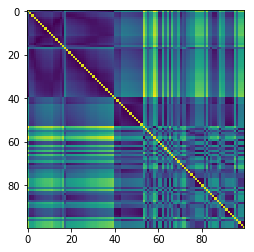

In [284]:
dists[dists==0.55] = 0.215
plt.imshow(dists)

In [44]:
# Postprocessing:
dists[dists < 0.0000001] = 99
potentials = dists < 0.02 # < ~100ft

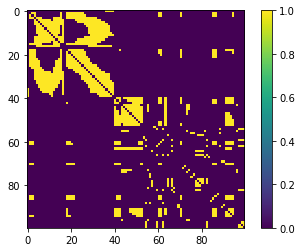

In [110]:
res = [X[r[0]] for r in np.array(np.where(potentials > 0)).T]
plt.imshow(potentials)
plt.colorbar()
plt.show()
_candidates = res
candidates = []
for c in _candidates:
    if tuple(c) not in candidates:
        candidates.append(tuple(c))
candidates = np.array(candidates)

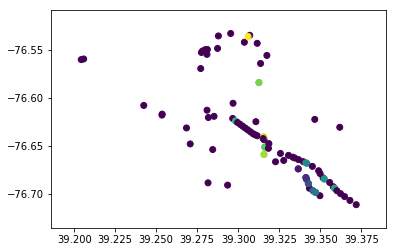

In [155]:
# Then, cluster:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=0.001, min_samples=2).fit(candidates)

# print(dbs.labels_)
plt.scatter(*candidates.T, c=dbs.labels_)
plt.show()

In [204]:
dbs.labels_

array([-1, -1, -1,  0,  1,  2,  3, -1,  4,  4,  5, -1,  3,  2,  1,  0,  5,
       -1, -1, -1, -1, -1, -1,  6,  6, -1, -1, -1, -1,  7,  7, -1, -1,  8,
        8, -1, -1, -1, -1, -1, -1, -1, -1,  9,  9, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, 10, 10, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, 11, 11, -1, -1, -1, -1, -1, -1, -1, -1, 12, 12, -1,
       -1, -1, -1, 13, 13, -1, -1, -1, 14, -1, 14])

In [228]:
counts = dbs.labels_
# Intersections are centroids of lights:
complex_intersections = [[] for _ in range(np.max(dbs.labels_))]
for i in range(len(candidates)):
    if dbs.labels_[i] > -1:
        light = candidates[i]
        complex_intersections[dbs.labels_[i]-1].append(light)
complex_intersections = np.array([np.array(c) for c in complex_intersections])

In [230]:
complex_intersections = [[np.mean(c[:, 0]), np.mean(c[:, 1])] for c in complex_intersections]

In [231]:
complex_intersections

[[39.341252449999999, -76.683056249999993],
 [39.341714449999998, -76.684977050000001],
 [39.34278415, -76.689357550000011],
 [39.345585200000002, -76.696768399999996],
 [39.347173900000001, -76.698554400000006],
 [39.341502500000004, -76.667863350000005],
 [39.352450099999999, -76.684485749999993],
 [39.3587974, -76.6941834],
 [39.298418999999996, -76.62412655],
 [39.316202449999999, -76.651276050000007],
 [39.3126186, -76.583939649999991],
 [39.315719850000001, -76.6588536],
 [39.3155912, -76.640733650000001],
 [39.321334049999997, -76.60498115]]

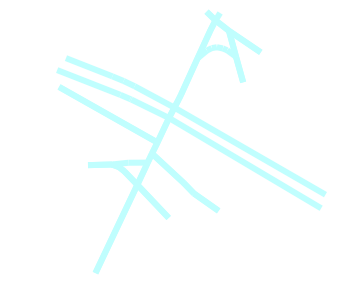

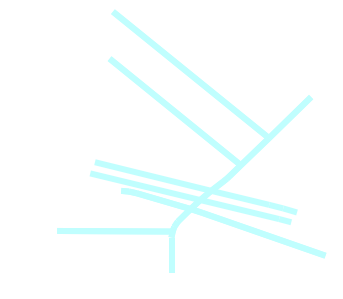

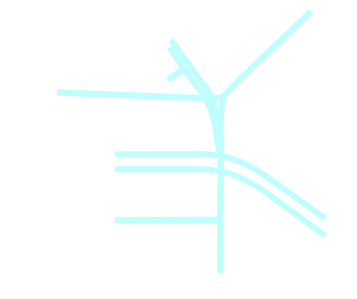

In [273]:
def clean_name(s):
    quals = ['avenue', 'street', 'place', 'way', 'drive', 'boulevard', 'road']
    s = s.lower()
    for qual in quals:
        if s.endswith(qual):
            return s[:len(qual)]
    return s

fnames = []
for ci in complex_intersections[:3]:
    gg = ox.graph_from_point(ci, distance=100, simplify=False, truncate_by_edge=True)
    rds = set([e[2].get('name') for e in gg.edges(data=True)])
    rds.remove(None)
    rds = [clean_name(r) for r in rds]
    rd_names = "{} & {}".format(", ".join(rds[:-1]), rds[-1])
    
    fname = rds[-1] + str(np.random.randint(0, 1000))
    fnames.append((fname, rd_names))
    
    ox.plot_graph(
        gg, 
        fig_height=5, fig_width=5, bgcolor="#55555500", 
        node_size=0, edge_linewidth=6, edge_color="#c0fefe",
        use_geom=True, 
        save=True, filename=fname
    )
    
with open('manifest.txt', 'a') as fh:
    fh.writelines(["{}\t{}\n".format(*fn) for fn in fnames])